In [ ]:
# https://www.kaggle.com/code/sakshaymahna/fully-convolutional-network
# https://www.youtube.com/watch?v=cPOtULagNnI

In [25]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate 
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
from matplotlib import pyplot as plt

In [27]:
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline
from IPython.display import HTML
from base64 import b64encode

In [28]:
# Load directories
train_data_dir = "../data/training/image_2/"
train_gt_dir = "../data/training/gt_image_2/"

test_data_dir = "../data/testing/"

In [29]:
# Number of training examples
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [30]:
# Initialize Constants
IMG_SIZE = 128 # 128x128
N_CHANNELS = 3 # rgb
N_CLASSES = 1
SEED = 123

In [71]:
image = tf.io.read_file('../data/training/image_2/um_000000.png')

In [72]:
image

<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xda\x00\x00\x01w\x08\x02\x00\x00\x00\xfcS\xb1\x8a\x00\x00 \x00IDATx\x01\x04\xc1Y\xccnYz\x18\xe4\xe7]{\xefo\xf8\xe73\x9f\x1aNuW\x8f\xb6\xbb\xdd\x1e\xe283\t$\x08\x1c\x12\xe4H\xc0\x05\x11\x11\x82DQ\xe0\x1a)\xe1\x82\xdbD\x88+\xb8@H\x89\x14\xc6\x1b\x84\x08RH\x84\xb138\x83bc\'\xb6{\xee\xea\xaa\xae\xae\xea\xae:\xf3?\x7f\xc3\xde{\xad\x97\xe7\x89\xcc\x04\x00\x00\x00\x00\x00\x00\x004\xd3\xce\xeb\x7f\xfe;G7\xdf\xfe?\xce/\xfe\xf7\xdf\xbe=\xee\xe7G\x87u}\xbd?\x9c\xae?\xfb\xe8\x0f\xb4\xd3/\xfe\xfc\xf6\xe4+\xd7\'\xc6\xa5\xd3\x8f\x1d\xec.\xca\xbb\xdf\xfdO\x16Gg\xf1\x8e\xf5\xb1\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x12\x00\xc0\xed\x85\xfe\x99\xf3\xb5_{\xc7\xc0\x9f\xe0!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x90\xbe\xf1m\xfb\x8f

In [73]:
image = tf.image.decode_jpeg(image, channels=3)

In [74]:
image # row , column, channel = 376, 1241, 3 

<tf.Tensor: shape=(375, 1242, 3), dtype=uint8, numpy=
array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [112, 133,  48],
        [ 97, 133,  53],
        [ 91, 112,  54]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 21,  76,  45],
        [ 23,  64,  44],
        [ 25,  66,  41]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 37,  29,  22],
        [ 49,  52,  15],
        [ 72,  89,  20]],

       ...,

       [[ 70,  83,  91],
        [ 71,  82,  89],
        [ 79,  80,  88],
        ...,
        [ 95,  99,  96],
        [ 95,  96,  96],
        [ 96,  93,  94]],

       [[ 74,  74,  72],
        [ 73,  71,  72],
        [ 80,  70,  71],
        ...,
        [ 95,  96,  96],
        [ 94,  97,  96],
        [ 93,  95,  95]],

       [[ 78,  70,  67],
        [ 78,  72,  71],
        [ 67,  75,  71],
        ...,
        [ 99,  94,  

In [50]:
image.shape

TensorShape([376, 1241, 3])

In [37]:
pix = [[[1,3,4],[4,5,6],[6,7,6]],
              [[1,2,3],[5,6,7],[9,7,8]],
              [[9,8,7],[8,7,6],[4,3,2]]]


# 3x3 pixel image  row = [[1,3,4],[4,5,6],[6,7,6]] with 3 column total no of rows 3
#   chanel = [1,2,3] rgb 3 chanel
# shape = (row, column, chanel)

In [38]:
pix = np.array(pix)

In [39]:
pix.shape

(3, 3, 3)

In [28]:
pix[0] # 1st row

array([[1, 3, 4],
       [4, 5, 6],
       [6, 7, 6]])

In [47]:
pix[0].shape[0] # no of columns

3

In [29]:
pix[0][0] # 1st row 1st pixel with rgb values

array([1, 3, 4])

In [30]:
pix[0][0][0]  # 1st row 1st pixel 1st value that is r value 

np.int64(1)

In [33]:
pix

array([[[1, 3, 4],
        [4, 5, 6],
        [6, 7, 6]],

       [[1, 2, 3],
        [5, 6, 7],
        [9, 7, 8]],

       [[9, 8, 7],
        [8, 7, 6],
        [4, 3, 2]]])

In [ ]:
# 3 dimensional
# axis = no  > [[[],[],[]]] # all # pix = [[[],[],[]]]
# axis = 0 > [[],[],[]], # over rows  pix[0] = [[],[],[]] # 1st row
#          [[],[],[]],
#          [[],[],[]], 

# axis = 1 > [],[],[]  # over columns pix[0][0] = [] # 1st row 1st pixel

# axis = 2  > [1,2,3]  # over chanel  pix[0][0][0] = 1 # 1st pixel 1st r value



In [40]:
pix2 = [[[[1,3,4],[4,5,6],[6,7,6]],
              [[1,2,3],[5,6,7],[9,7,8]],
              [[9,8,7],[8,7,6],[4,3,2]]],

              [[[1,3,4],[4,5,6],[6,7,6]],
              [[1,2,3],[5,6,7],[9,7,8]],
              [[9,8,7],[8,7,6],[4,3,2]]]]

# 1 batch with 2 image with
# 3x3 pixel image  row = [[1,3,4],[4,5,6],[6,7,6]] with 3 column total no of rows 3
#   chanel = [1,2,3] rgb 3 chanel
# shape = (row, column, chanel)

In [41]:
pix2 = np.array(pix2)

In [42]:
pix2.shape # batch size = 2 images , row, column, chanel # 4 dimensions

(2, 3, 3, 3)

In [43]:
pix2[0] #  1st image of the batch

array([[[1, 3, 4],
        [4, 5, 6],
        [6, 7, 6]],

       [[1, 2, 3],
        [5, 6, 7],
        [9, 7, 8]],

       [[9, 8, 7],
        [8, 7, 6],
        [4, 3, 2]]])

In [44]:
pix2[0][0] #  1st row of 1st image of the batch

array([[1, 3, 4],
       [4, 5, 6],
       [6, 7, 6]])

In [48]:
pix2[0][0].shape[0] #column no

3

In [45]:
pix2[0][0][0] #1st pixel of 1st row of 1st image of the batch

array([1, 3, 4])

In [49]:
pix2[0][0][0][0] # r value

np.int64(1)

In [ ]:
# 4 dimensional
# aixs = no > [[[[],[],[]],[[],[],[]]]] # all # pix = [[[[],[],[]],[[],[],[]]]]
# axis = 0  > [[[],[],[]]],[[[],[],[]]] # over image of the batch  pix[0] = [[[],[],[]]]
# axis = 1 > [[],[],[]], # over rows  pix[0][0] = [[],[],[]] # 1st row
#          [[],[],[]],
#          [[],[],[]], 

# axis = 2 > [],[],[]  # over columns pix[0][0][0] = [] # 1st row 1st pixel

# axis = 3  > [1,2,3]  # over chanel  pix[0][0][0][0] = 1 # 1st pixel 1st r value


Axis Order:

In most libraries, including NumPy and TensorFlow, the axis order in a 3D tensor array is:

Axis 0: First dimension (e.g., batch size or number of samples)

Axis 1: Second dimension (e.g., height or number of rows)

Axis 2: Third dimension (e.g., width or number of columns)

In [31]:
import tensorflow as tf

# Create a 3D tensor array
tensor = tf.random.uniform((3, 4, 5))

# Check the shape of the tensor
print(tensor.shape)  # Output: (3, 4, 5)

# Check the number of dimensions
print(tf.rank(tensor))  # Output: 3

(3, 4, 5)
tf.Tensor(3, shape=(), dtype=int32)


In [32]:
tensor # row, column , channel

<tf.Tensor: shape=(3, 4, 5), dtype=float32, numpy=
array([[[0.26295006, 0.42677724, 0.5095104 , 0.5767609 , 0.32996595],
        [0.41624594, 0.26501834, 0.24350679, 0.7474686 , 0.65989184],
        [0.1198144 , 0.32819915, 0.53082097, 0.76708555, 0.33546507],
        [0.7210735 , 0.28307998, 0.5032344 , 0.02575028, 0.6606395 ]],

       [[0.119573  , 0.91343987, 0.44366896, 0.76996076, 0.5281334 ],
        [0.64875567, 0.64650905, 0.26084948, 0.36591625, 0.9597374 ],
        [0.4998983 , 0.04708171, 0.14350414, 0.7830485 , 0.38384843],
        [0.7557893 , 0.74460936, 0.16587472, 0.42874157, 0.70069015]],

       [[0.1427573 , 0.24481785, 0.00335169, 0.21168423, 0.6823069 ],
        [0.6995145 , 0.7577579 , 0.79138243, 0.42417657, 0.8032615 ],
        [0.7692232 , 0.21261394, 0.7197424 , 0.8103205 , 0.74908864],
        [0.17101347, 0.6029781 , 0.24685514, 0.0637958 , 0.9470725 ]]],
      dtype=float32)>

In [58]:
image = tf.image.convert_image_dtype(image, tf.uint8)

In [76]:
image

<tf.Tensor: shape=(375, 1242, 3), dtype=uint8, numpy=
array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [112, 133,  48],
        [ 97, 133,  53],
        [ 91, 112,  54]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 21,  76,  45],
        [ 23,  64,  44],
        [ 25,  66,  41]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 37,  29,  22],
        [ 49,  52,  15],
        [ 72,  89,  20]],

       ...,

       [[ 70,  83,  91],
        [ 71,  82,  89],
        [ 79,  80,  88],
        ...,
        [ 95,  99,  96],
        [ 95,  96,  96],
        [ 96,  93,  94]],

       [[ 74,  74,  72],
        [ 73,  71,  72],
        [ 80,  70,  71],
        ...,
        [ 95,  96,  96],
        [ 94,  97,  96],
        [ 93,  95,  95]],

       [[ 78,  70,  67],
        [ 78,  72,  71],
        [ 67,  75,  71],
        ...,
        [ 99,  94,  

In [77]:
mask = tf.io.read_file('../data/training/gt_image_2/um_lane_000000.png')

In [78]:
mask = tf.image.decode_png(mask, channels=3)

In [79]:
mask

<tf.Tensor: shape=(375, 1242, 3), dtype=uint8, numpy=
array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       ...,

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,  

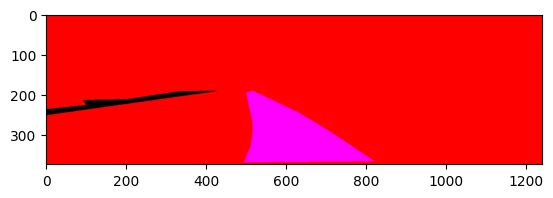

In [81]:
plt.imshow(mask)
plt.show()

In [31]:
non_road_label = np.array([255, 0, 0]) # red
road_label = np.array([255, 0, 255]) # red and blue > purple
other_road_label = np.array([0, 0, 0]) # black

In [32]:
mask = tf.experimental.numpy.all(mask == road_label, axis = 2) # pixel value axis 2 0r -1 for a rgb image
# Comparison each pixel: mask == road_label performs an element-wise comparison between the mask tensor and 
# the road_label value. This produces a boolean tensor where each element is True if the corresponding
# element in mask is equal to road_label, and False otherwise.

In [84]:
mask  # set road pixel value to 1(without array) otherwise 0 value like  1 chanel 2d array only 2 color

<tf.Tensor: shape=(375, 1242), dtype=bool, numpy=
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])>

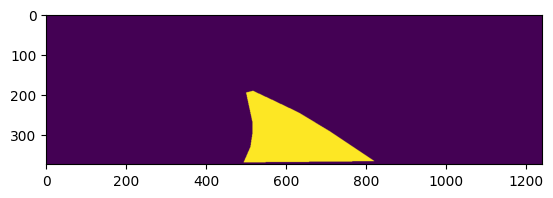

In [85]:
plt.imshow(mask)
plt.show()

In [65]:
mask = tf.cast(mask, tf.uint8)

In [66]:
mask

<tf.Tensor: shape=(375, 1242), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

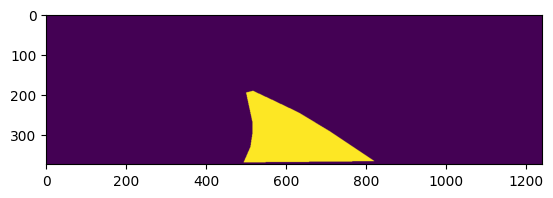

In [86]:
plt.imshow(mask)
plt.show()

In [67]:
mask = tf.expand_dims(mask, axis=-1) # make 3d add axis 2 or -1(last axis) that is pixel array with single element b/w


In [68]:
mask # one chanel

<tf.Tensor: shape=(375, 1242, 1), dtype=uint8, numpy=
array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)>

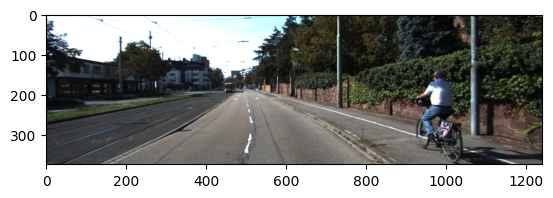

In [75]:
plt.imshow(image)
plt.show()

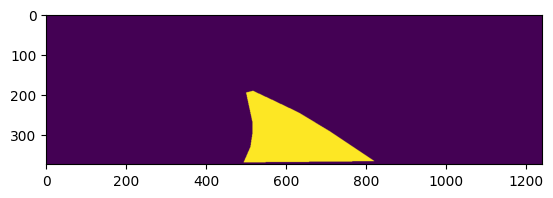

In [70]:
plt.imshow(mask)
plt.show()

In [33]:
# Function to load image and return a dictionary
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Three types of img paths: um, umm, uu
    # gt image paths: um_road, umm_road, uu_road
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)

    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])
    
    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask} # crate batch of image and segmentation_mask in dict object

In [34]:
# Generate dataset variables
all_dataset = tf.data.Dataset.list_files(train_data_dir + "*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image)

In [96]:
next(iter(all_dataset.take(1))) # take one batch

{'image': <tf.Tensor: shape=(375, 1242, 3), dtype=uint8, numpy=
 array([[[134, 202, 255],
         [132, 202, 255],
         [130, 203, 255],
         ...,
         [  8,  12,   9],
         [ 11,  13,   9],
         [ 16,  14,   9]],
 
        [[135, 201, 255],
         [135, 201, 255],
         [132, 202, 255],
         ...,
         [ 10,  11,   9],
         [ 10,  12,   8],
         [  9,  15,   8]],
 
        [[131, 202, 255],
         [132, 202, 255],
         [130, 202, 255],
         ...,
         [ 10,  11,   7],
         [ 10,  13,   6],
         [ 11,  18,   7]],
 
        ...,
 
        [[117, 104, 107],
         [122, 110, 111],
         [114, 118, 114],
         ...,
         [ 12,  15,  13],
         [ 12,  15,  13],
         [ 12,  17,  13]],
 
        [[124, 111, 114],
         [125, 121, 115],
         [112, 120, 117],
         ...,
         [ 12,  17,  10],
         [ 12,  16,  10],
         [ 12,  16,  11]],
 
        [[122, 116, 117],
         [121, 121, 115],
    

In [95]:
next(iter(all_dataset.take(1)))['image']

<tf.Tensor: shape=(375, 1242, 3), dtype=uint8, numpy=
array([[[156, 222, 255],
        [157, 221, 255],
        [158, 221, 255],
        ...,
        [ 63,  76,  49],
        [ 56,  76,  61],
        [ 51,  67,  60]],

       [[157, 224, 255],
        [157, 224, 255],
        [159, 223, 255],
        ...,
        [ 42,  79,  49],
        [ 46,  79,  54],
        [ 54,  70,  50]],

       [[161, 221, 255],
        [161, 223, 255],
        [161, 223, 255],
        ...,
        [ 41,  58,  40],
        [ 46,  61,  40],
        [ 53,  56,  39]],

       ...,

       [[ 52,  56,  56],
        [ 52,  56,  60],
        [ 52,  54,  62],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 52,  55,  56],
        [ 52,  54,  59],
        [ 52,  54,  59],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 55,  57,  56],
        [ 55,  58,  59],
        [ 55,  59,  59],
        ...,
        [255, 250, 2

In [98]:
next(iter(all_dataset.take(1)))['segmentation_mask']

<tf.Tensor: shape=(376, 1241, 1), dtype=uint8, numpy=
array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)>

In [99]:
next(iter(all_dataset)) # iter over batch or dict object

{'image': <tf.Tensor: shape=(376, 1241, 3), dtype=uint8, numpy=
 array([[[170, 172, 136],
         [169, 173, 137],
         [167, 173, 137],
         ...,
         [117, 116, 173],
         [118,  88, 116],
         [106,  73,  82]],
 
        [[174, 170, 133],
         [176, 171, 135],
         [171, 172, 137],
         ...,
         [123, 115, 167],
         [128,  87, 110],
         [105,  72,  86]],
 
        [[170, 169, 129],
         [172, 169, 132],
         [170, 170, 135],
         ...,
         [123, 113, 161],
         [129,  87, 105],
         [103,  74,  90]],
 
        ...,
 
        [[138, 148, 136],
         [158, 138, 137],
         [164, 141, 134],
         ...,
         [ 40,  34,  31],
         [ 46,  37,  31],
         [ 49,  42,  33]],
 
        [[163, 157, 136],
         [160, 151, 140],
         [163, 148, 142],
         ...,
         [ 23,  25,  33],
         [ 22,  26,  33],
         [ 23,  27,  34]],
 
        [[163, 169, 168],
         [159, 169, 170],
    

In [100]:
next(iter(all_dataset))['image']

<tf.Tensor: shape=(375, 1242, 3), dtype=uint8, numpy=
array([[[ 55,  59,  33],
        [ 57,  61,  62],
        [ 66,  67,  70],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 58,  64,  61],
        [ 60,  71,  31],
        [ 79,  66,  31],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 43,  60,  69],
        [ 45,  61,  32],
        [ 43,  54,  16],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 69,  75,  81],
        [ 65,  74,  76],
        [ 74,  71,  74],
        ...,
        [ 50,  62,  38],
        [ 54,  63,  38],
        [ 52,  62,  35]],

       [[ 64,  78,  73],
        [ 63,  75,  82],
        [ 76,  73,  89],
        ...,
        [ 48,  77,  62],
        [ 48,  69,  63],
        [ 49,  61,  54]],

       [[ 85,  76,  72],
        [ 88,  81,  85],
        [ 74,  84,  88],
        ...,
        [ 46,  78,  

In [101]:
next(iter(all_dataset))['segmentation_mask']

<tf.Tensor: shape=(375, 1242, 1), dtype=uint8, numpy=
array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]],

       [[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]],

       [[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)>

In [105]:
len(os.listdir(train_data_dir))

289

In [102]:
TRAINSET_SIZE

231

In [103]:
VALIDSET_SIZE

28

In [106]:
289-231-28

30

In [35]:
train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE) # take 259 batch
val_dataset = train_dataset.skip(TRAINSET_SIZE) # 28
train_dataset = train_dataset.take(TRAINSET_SIZE) # 231
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE) # 30

In [108]:
IMG_SIZE

128

In [36]:
# Tensorflow function to rescale images to [0, 1]
@tf.function # tensorflow operations
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Tensorflow function to apply preprocessing transformations
@tf.function # tensorflow operations
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Tensorflow function to preprocess validation images
@tf.function # tensorflow operations
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [ ]:
# This code snippet is used to randomly flip an image and its corresponding mask horizontally (left to right) with a 50% probability.
# Here's a breakdown:
# tf.random.uniform(()) > 0.5:
# Generates a random number between 0 and 1.
# If the number is greater than 0.5, the condition is true.
# tf.image.flip_left_right(input_image):
# Flips the input_image horizontally (left to right).
# tf.image.flip_left_right(input_mask):
# Flips the input_mask horizontally (left to right) to maintain alignment with the flipped image.
# This technique is commonly used in image augmentation for machine learning model training. By randomly flipping images, you can:
# Increase the diversity of your training dataset.
# Reduce overfitting by exposing the model to different orientations.
# Improve the model's ability to recognize patterns regardless of orientation.

In [37]:
train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE) # take 259 batch
val_dataset = train_dataset.skip(TRAINSET_SIZE) # 28
train_dataset = train_dataset.take(TRAINSET_SIZE) # 231
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE) # 30

In [ ]:
# all_dataset = {'image': image, 'segmentation_mask': mask}
# train_dataset = {'image': image, 'segmentation_mask': mask}
# val_dataset = {'image': image, 'segmentation_mask': mask}
# test_dataset = {'image': image, 'segmentation_mask': mask}

In [38]:
BATCH_SIZE = 32 # 32 images in a batch
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset} # dict under dict  


# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)
#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

print(dataset['train']) # iput_image, input_mask
print(dataset['val'])
print(dataset['test'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


In [ ]:
next(iter(dataset['train'])) # 32 images in a batch take one batch

(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
 array([[[[0.1463775 , 0.2087394 , 0.10081691],
          [0.06573175, 0.07717429, 0.05001484],
          [0.12403493, 0.17390412, 0.13122763],
          ...,
          [0.02049082, 0.0311302 , 0.0273465 ],
          [0.01177225, 0.01904859, 0.01554087],
          [0.04632102, 0.02747156, 0.02490809]],
 
         [[0.2594693 , 0.30111238, 0.3505169 ],
          [0.08155566, 0.08482726, 0.05913576],
          [0.04698941, 0.0630997 , 0.04056959],
          ...,
          [0.01473652, 0.02257966, 0.01416853],
          [0.00844858, 0.01215569, 0.01878794],
          [0.02580411, 0.04720423, 0.02959535]],
 
         [[0.08722582, 0.08985392, 0.05028279],
          [0.11850969, 0.17319946, 0.09184343],
          [0.03529412, 0.05753832, 0.03810341],
          ...,
          [0.00843901, 0.02039065, 0.01568628],
          [0.01176471, 0.01482017, 0.00533794],
          [0.03777143, 0.04101347, 0.03137255]],
 
         ...,
 
      

In [114]:
next(iter(dataset['train']))[0] # take 1st set of image and mask of the batch

<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[0.21176471, 0.30481076, 0.39942005],
         [0.19277176, 0.27800244, 0.35686275],
         [0.20174633, 0.28197092, 0.37931985],
         ...,
         [0.07066028, 0.09705523, 0.06139538],
         [0.16691177, 0.20995711, 0.19734748],
         [0.16623631, 0.18140462, 0.20340936]],

        [[0.20977329, 0.29148284, 0.38198313],
         [0.2073223 , 0.26963848, 0.36137122],
         [0.20855856, 0.28235295, 0.36788306],
         ...,
         [0.12079528, 0.1469164 , 0.1228554 ],
         [0.19280024, 0.25634837, 0.26291072],
         [0.11702737, 0.13554353, 0.09658156]],

        [[0.20873521, 0.28293505, 0.38053817],
         [0.1875    , 0.27840075, 0.34495562],
         [0.21224222, 0.2848293 , 0.40114626],
         ...,
         [0.12753332, 0.12016985, 0.10692402],
         [0.2055901 , 0.2951014 , 0.28716037],
         [0.1137219 , 0.15174991, 0.1482915 ]],

        ...,

        [[0.05521192, 0.07760776,

In [115]:
next(iter(dataset['train']))[0][0] # take image of 1st set of image and mask of the batch

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.07534982, 0.15414633, 0.19857286],
        [0.09433211, 0.17233455, 0.22388197],
        [0.09366634, 0.16954382, 0.19226134],
        ...,
        [0.06030944, 0.09859499, 0.07748593],
        [0.09672229, 0.14974006, 0.10901561],
        [0.18509449, 0.27321824, 0.11102642]],

       [[0.07821691, 0.16296734, 0.19772531],
        [0.09721201, 0.18034692, 0.21159548],
        [0.09050951, 0.18305054, 0.21207814],
        ...,
        [0.09641784, 0.12008272, 0.26447743],
        [0.07800245, 0.11000306, 0.05830485],
        [0.08109729, 0.13112865, 0.10402976]],

       [[0.08489583, 0.16059774, 0.19353554],
        [0.10588235, 0.18521753, 0.22404198],
        [0.09837312, 0.1874525 , 0.21176471],
        ...,
        [0.06963848, 0.09523591, 0.0565626 ],
        [0.08683304, 0.1069075 , 0.05490196],
        [0.12086947, 0.12039459, 0.07639124]],

       ...,

       [[0.19834666, 0.1756143 , 0.11722795],
        [0.14

In [116]:
next(iter(dataset['train']))[0][1] # take mask of 2nd set of image and mask of the batch

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.01871936, 0.01725129, 0.02758885],
        [0.03137255, 0.0350872 , 0.03585337],
        [0.02745098, 0.03137255, 0.03543198],
        ...,
        [0.43514955, 0.6732101 , 0.996507  ],
        [0.41649887, 0.6310195 , 0.9242411 ],
        [0.41624802, 0.4784997 , 0.65429676]],

       [[0.0229704 , 0.03536293, 0.03604473],
        [0.02355203, 0.02394301, 0.03161693],
        [0.01724052, 0.02394301, 0.04092431],
        ...,
        [0.44908088, 0.69175977, 0.99885935],
        [0.4493486 , 0.6977722 , 0.9995864 ],
        [0.44705883, 0.6860063 , 0.9953427 ]],

       [[0.03137255, 0.04636949, 0.06876256],
        [0.0189185 , 0.01978461, 0.02814032],
        [0.01568628, 0.01908545, 0.03400891],
        ...,
        [0.44294876, 0.6962791 , 0.99607843],
        [0.45490196, 0.70385206, 0.99851996],
        [0.44704902, 0.6984862 , 0.98221785]],

       ...,

       [[0.3335478 , 0.31855085, 0.29408976],
        [0.38

In [117]:
next(iter(dataset['train'].take(1)))[0] # 1st set  of image and mask of one batch

<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[0.04852941, 0.04063481, 0.06519608],
         [0.1408689 , 0.13327326, 0.13765559],
         [0.0446447 , 0.04585176, 0.04831495],
         ...,
         [0.5976656 , 0.5849571 , 0.47415435],
         [0.623011  , 0.6000613 , 0.47849384],
         [0.58836764, 0.584723  , 0.47486764]],

        [[0.05229779, 0.04313726, 0.05052083],
         [0.13675752, 0.12950368, 0.12612998],
         [0.03951608, 0.0375    , 0.05176499],
         ...,
         [0.61678326, 0.59860337, 0.48112148],
         [0.5982032 , 0.5951557 , 0.493559  ],
         [0.57677937, 0.582413  , 0.4828137 ]],

        [[0.05102324, 0.04129902, 0.04207716],
         [0.12947305, 0.14444867, 0.15593693],
         [0.04313726, 0.03504878, 0.04846814],
         ...,
         [0.62386715, 0.61859655, 0.4928615 ],
         [0.61178935, 0.57487744, 0.4909747 ],
         [0.57096213, 0.56784934, 0.49311283]],

        ...,

        [[0.10061897, 0.11571691,

In [118]:
next(iter(dataset['train'].take(1)))[0][0] # take image of the set of image and mask of the batch

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.49056098, 0.75000525, 1.        ],
        [0.4819469 , 0.75686276, 1.        ],
        [0.4892463 , 0.7733943 , 1.        ],
        ...,
        [0.24414553, 0.17260048, 0.1721688 ],
        [0.17416525, 0.17185968, 0.16009498],
        [0.19988248, 0.1729905 , 0.16344473]],

       [[0.44679135, 0.7177694 , 0.9994636 ],
        [0.48646635, 0.6856851 , 0.8951447 ],
        [0.5055913 , 0.7796651 , 1.        ],
        ...,
        [0.19041641, 0.16015744, 0.15729873],
        [0.1915142 , 0.16551776, 0.13439032],
        [0.19724265, 0.1658239 , 0.11771611]],

       [[0.46181342, 0.65519065, 0.8667193 ],
        [0.38815883, 0.68658805, 0.9970918 ],
        [0.37047502, 0.6826624 , 1.        ],
        ...,
        [0.2059836 , 0.1602879 , 0.13183366],
        [0.2       , 0.15818602, 0.1377098 ],
        [0.12892707, 0.13817677, 0.12776285]],

       ...,

       [[0.25348714, 0.20919393, 0.16071872],
        [0.38

In [131]:
sample_images = next(iter(dataset['train'].take(1)))[0] # images from set of image and mask unchanged dimensions thai is 4

In [132]:
sample_images # this is 4 dimensions but to produce image we need 3 dimensions

<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[0.24165434, 0.16502506, 0.247319  ],
         [0.21265319, 0.28429767, 0.41903278],
         [0.21267712, 0.3264117 , 0.5487    ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.3526122 , 0.5510786 , 0.864482  ],
         [0.23087218, 0.3153208 , 0.47960934],
         [0.22252545, 0.4051728 , 0.50417376],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.4206786 , 0.65576804, 0.9056121 ],
         [0.15736707, 0.29755968, 0.43287113],
         [0.22729133, 0.41019443, 0.47711086],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [0.9979041 , 1.        , 1.        ]],

        ...,

        [[0.34761304, 0.34396172,

In [133]:
sample_images[0] # it has 3 dimensions

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.24165434, 0.16502506, 0.247319  ],
        [0.21265319, 0.28429767, 0.41903278],
        [0.21267712, 0.3264117 , 0.5487    ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.3526122 , 0.5510786 , 0.864482  ],
        [0.23087218, 0.3153208 , 0.47960934],
        [0.22252545, 0.4051728 , 0.50417376],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.4206786 , 0.65576804, 0.9056121 ],
        [0.15736707, 0.29755968, 0.43287113],
        [0.22729133, 0.41019443, 0.47711086],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.9979041 , 1.        , 1.        ]],

       ...,

       [[0.34761304, 0.34396172, 0.32022765],
        [0.37

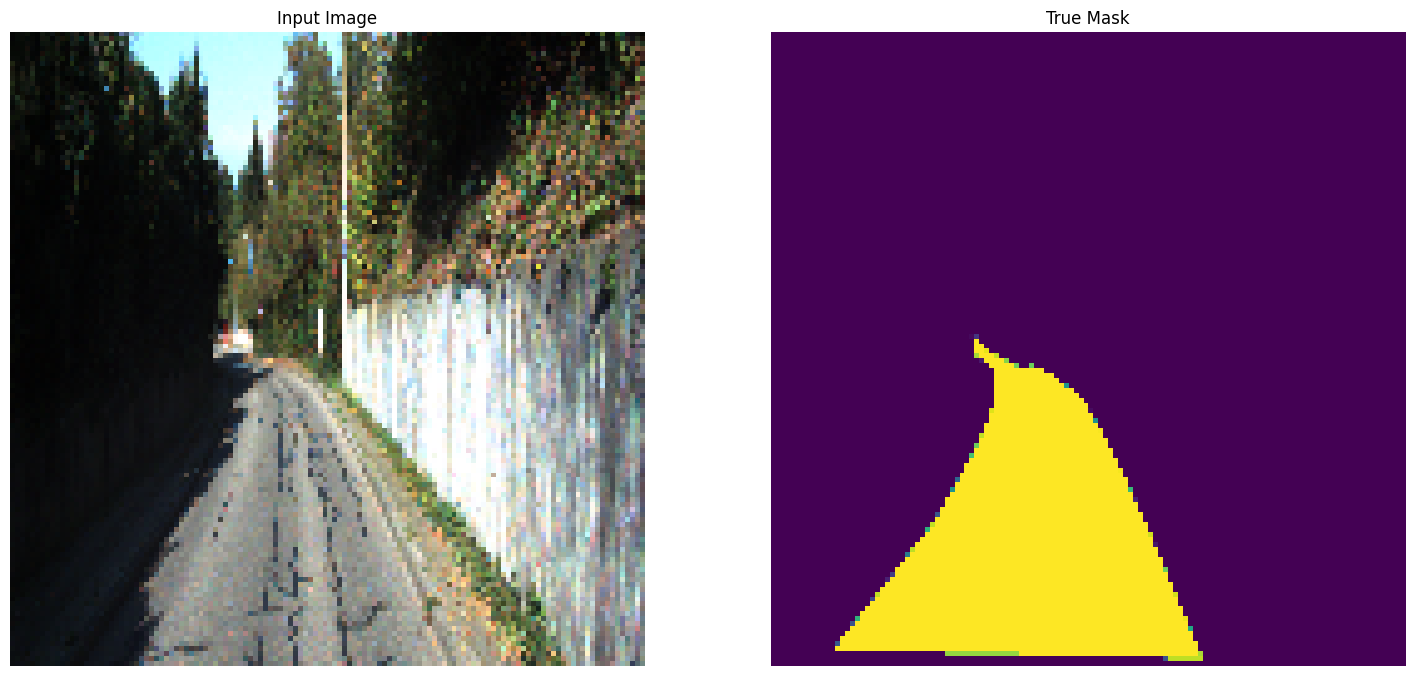

In [39]:
# Function to view the images from the directory
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for image, mask in dataset["train"].take(1):
    sample_image, sample_mask = image, mask # create set of (images)(4d) and set of (masks)(4d) from set of (imaegs and masks)(4d) including batcccch size

display_sample([sample_image[0], sample_mask[0]]) # 1st image(3d) for set of images(4d) and 1st mask(3d) for set of masks(4d)

In [40]:
# Get VGG-16 network as backbone
vgg16_model = VGG16() # this is classification or detection model predict object
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Define input shape
input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [123]:
input_shape

(128, 128, 3)

In [124]:
N_CLASSES  # mask output

1

In [42]:
# Generate a new model using the VGG network
# Input
inputs = Input(input_shape) # vgg input layer replace by this layer include top false

# VGG network
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = inputs)

# Encoder Layers
c1 = vgg16_model.get_layer("block3_pool").output         
c2 = vgg16_model.get_layer("block4_pool").output
c3 = vgg16_model.get_layer("block5_pool").output
# Decoder
u1 = UpSampling2D((2, 2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2]) # add u1 to output of block5_pool layer

u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Output
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
outputs = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(u3)

model = Model(inputs, outputs, name = "VGG_FCN8")       # create U net model for segmentation predict mask

In [43]:
model.summary()

Model: "VGG_FCN8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer_3[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 14,715,969 (56.14 MB)

 Trainable params: 14,715,969 (56.14 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[m_iou])

In [ ]:
# This line of code is used to calculate the Mean Intersection over Union (IoU) metric for evaluating the performance of a semantic segmentation model in TensorFlow.
# Here's a breakdown:
# tf.keras.metrics.MeanIoU: This is a TensorFlow metric that calculates the mean IoU score for semantic segmentation tasks.
# num_classes=2: This specifies the number of classes in the segmentation task. In this case, it's set to 2, which means the model is segmenting images into two classes (e.g., foreground and background).
# Mean IoU is a widely used metric for evaluating semantic segmentation models. It measures the overlap between the predicted segmentation mask and the ground-truth mask.
# The IoU score for each class is calculated as:
# IoU = (TP / (TP + FP + FN))
# Where:
# TP: True Positives (pixels correctly predicted as belonging to the class)
# FP: False Positives (pixels incorrectly predicted as belonging to the class)
# FN: False Negatives (pixels incorrectly predicted as not belonging to the class)

In [45]:
# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)
    
    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            true_mask = mask
            display_sample([image[0], true_mask[0], create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])
        
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


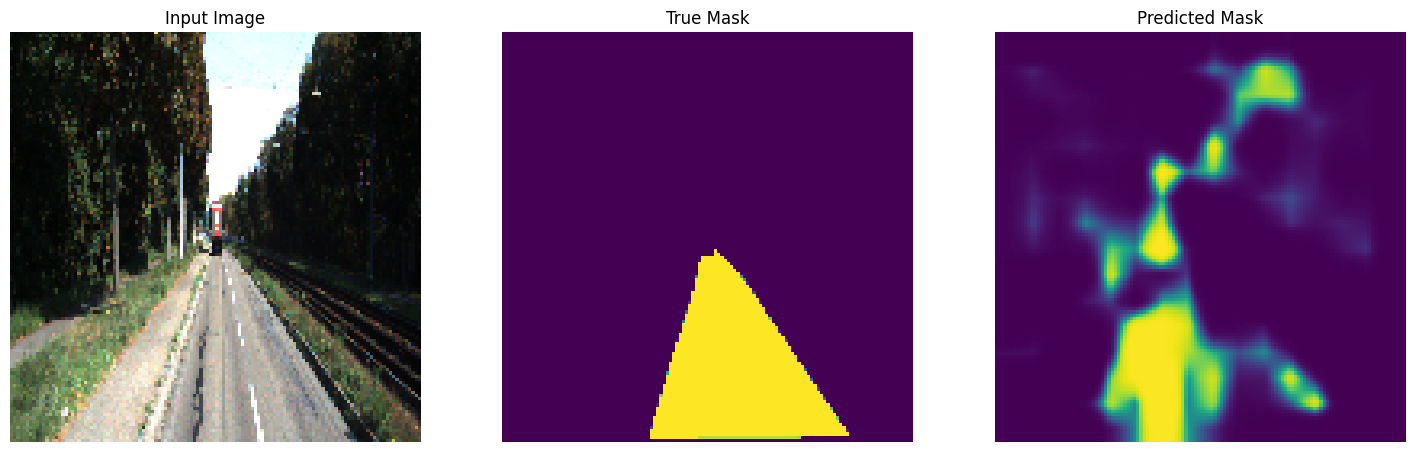

In [46]:
show_predictions()

In [ ]:
# This code defines a custom callback class DisplayCallback and sets up a list of callbacks for a Keras model. Here's a breakdown:
# DisplayCallback Class:
# This class inherits from Keras' callbacks.Callback and defines a custom callback that displays predictions after each epoch.
# on_epoch_end Method:
# This method is called at the end of each epoch. It:
# Clears the output using clear_output(wait=True).
# Calls the show_predictions() function to display predictions.
# Prints a message indicating the current epoch number.
# Callbacks List:
# The code sets up a list of callbacks for the Keras model:
# DisplayCallback(): The custom callback class instance.
# callbacks.TensorBoard(logdir, histogram_freq=-1):
# Enables TensorBoard logging.
# # logdir: The directory where TensorBoard logs are stored.
# histogram_freq=-1: Disables histogram logging.
# # callbacks.EarlyStopping(patience=10, verbose=1)
# Enables early stopping.
# patience=10: Stops training if the model doesn't improve for 10 consecutive epochs.
# verbose=1: Displays early stopping information.
# callbacks.ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True):
# Enables model checkpointing.
# best_model.keras: The file path where the best model is saved.
# verbose=1: Displays checkpointing information.
# save_best_only=True: Saves only the best-performing model.
# These callbacks will be used during training to display predictions, log TensorBoard metrics, stop training early if necessary, and save the best-performing model.


In [47]:
# Callbacks and Logs
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.keras', verbose = 1, save_best_only = True)
]
# Set Variables
EPOCHS = 10
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALIDSET_SIZE // BATCH_SIZE

In [48]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = dataset["val"],
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - loss: 27.0063 - mean_io_u_1: 0.3954 

KeyboardInterrupt: 

In [ ]:
# This code defines two functions:
# weighted_img: Combines two images using weighted addition.
# process_image_mask: Processes an individual image and its corresponding mask.
# weighted_img Function:
# Purpose:
# This function combines two images, img and initial_img, using weighted addition.
# Parameters:
# img: The first image.
# initial_img: The second image.
# α (alpha): The weight for the initial_img (default: 1.0).
# β (beta): The weight for the img (default: 0.5).
# γ (gamma): The constant value added to the weighted sum (default: 0.0).
# Return Value:
# Purpose:
# This function processes an individual image and its corresponding mask.
# Parameters:
# image: The input image.
# mask: The corresponding mask.
# Steps:
# Round the mask values: Rounds the mask values to the closest integer using tf.math.round.
# Convert the mask to an image: Creates a three-channel image from the mask by stacking the mask with two zero channels.
# Convert the image to a float32 array: Converts the image to a float32 NumPy array.
# Combine the image and mask: Uses the weighted_img function to combine the image and mask.

In [ ]:
# Function to calculate mask over image
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    
    # Convert to image image
    image = np.asarray(image, np.float32)
    
    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [ ]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])],index)
            index += 1

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))

        plt.savefig(f'output/{index}.png')
        plt.close()

In [ ]:
os.mkdir("outputs")
save_predictions(dataset['test'])

In [ ]:
# Function to view video
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [ ]:
# Function to process an individual image
def process_image(image):
    # Preprocess image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Get the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)

     # Get the final image
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
# Make a new directory
os.mkdir("videos")

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "project_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)


In [ ]:
# Creating a VideoCapture object to read the video
project_video = "challenge.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "challenge_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()


In [ ]:
# Read Video File:
# project_video = "challenge_video.mp4": Specifies the input video file.
# original_video = cv2.VideoCapture(test_data_dir + project_video): Opens the video file using OpenCV's VideoCapture function.
# Get Video Properties:
# frame_width = int(original_video.get(3)): Retrieves the video frame width.
# frame_height = int(original_video.get(4)): Retrieves the video frame height.
# Create Video Writer:
# fourcc = cv2.VideoWriter_fourcc('m','p','4','v'): Specifies the video codec (in this case, MP4V).
# fps = 60: Sets the output video frame rate.
# output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height)): Creates a VideoWriter object to write the processed frames to a new video file.
# Process Video Frames:
# while(original_video.isOpened()):: Loops through the video frames until the end of the video is reached.
# ret, frame = original_video.read(): Reads a frame rom the video.
# if ret == True:: Checks if the frame was read successfully.
# output.write(process_image(frame)): Processes the frame using the process_image function and writes the processed frame to the output video.
# Release Resources:
# original_video.release(): Releases the VideoCapture object.
# output.release(): Releases the VideoWriter object.
# 


In [ ]:
play("videos/" + project_video)

In [ ]:
# Creating a VideoCapture object to read the video
project_video = "harder_challenge_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

In [ ]:
# 49:07